# Gigs Senior Data Analyst Challenge

Welcome to the Gigs data analyst take-home challenge! This notebook will help you get started with analyzing our connectivity usage data.

## About the Data

You'll be working with three main datasets:
- **Usage Data**: Detailed usage per subscription period (~100K+ records)
- **Plan Events**: Plan configuration and pricing history
- **Projects**: Project metadata

## Setup Instructions

Run the cells below to set up your environment and load the data into DuckDB.

In [1]:
# Import required libraries
import duckdb
import pandas as pd
from datetime import datetime, timedelta

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


In [2]:
# Load JupySQL extension and configure
%load_ext sql

# Configure JupySQL for better output
%config SqlMagic.autopandas = True
%config SqlMagic.feedback = False
%config SqlMagic.displaycon = False

print("✅ JupySQL configured!")

✅ JupySQL configured!


In [3]:
# Connect to DuckDB
conn = duckdb.connect('gigs-analytics.db')
%sql conn --alias duckdb

print("✅ Connected to DuckDB database: gigs-analytics.db")

✅ Connected to DuckDB database: gigs-analytics.db


In [4]:
%%sql
-- Load data into DuckDB tables
CREATE
OR REPLACE TABLE usage_data AS
SELECT
  *
FROM
  'data/usage_by_subscription_period.csv';

CREATE
OR REPLACE TABLE plan_events AS
SELECT
  *
FROM
  'data/plan_change_events.csv';

CREATE
OR REPLACE TABLE projects AS
SELECT
  *
FROM
  'data/projects.csv';

,Count
0,3


In [5]:
%%sql
-- Verify data loading
SELECT
  'usage_data' AS table_name,
  COUNT(*) AS row_count,
  COUNT(DISTINCT subscription_id) AS unique_subscriptions
FROM
  usage_data
UNION ALL
SELECT
  'plan_events' AS table_name,
  COUNT(*) AS row_count,
  COUNT(DISTINCT plan_id) AS unique_plans
FROM
  plan_events
UNION ALL
SELECT
  'projects' AS table_name,
  COUNT(*) AS row_count,
  COUNT(DISTINCT project_id__hashed) AS unique_projects
FROM
  projects;

,table_name,row_count,unique_subscriptions
0,usage_data,53565,8457
1,plan_events,209,36
2,projects,3,3


## Your Analysis Starts Here!

Now you have everything set up. Use the cells below to start your analysis.

### Tips:
- Use `%%sql` for multi-line SQL queries
- Use `%sql variable_name <<` to store results in a Python variable
- Combine SQL with Python/Pandas for advanced analysis
- Feel free to use any visualisation library you feel comfortable with

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
pd.set_option("display.max_columns", None)
pd.set_option("display.float_format", lambda v: f"{v:,.2f}")

In [7]:
%config SqlMagic.autopandas = True

### 0. EDA

#### 0.1 Usage data

In [8]:
%%sql usage <<
SELECT
  *
FROM
  usage_data

* Each row corresponds to a reporting period for a subscription.
* There are 8457 distinct subscriptions 12 distinct plans and 3 distinct projects.

In [9]:
%%sql
SELECT
  COUNT(subscription_id),
  COUNT(DISTINCT subscription_id),
  COUNT(plan_id),
  COUNT(DISTINCT plan_id),
  COUNT(project_id__hashed),
  COUNT(DISTINCT project_id__hashed)
FROM
  usage

,count(subscription_id),count(DISTINCT subscription_id),count(plan_id),count(DISTINCT plan_id),count(project_id__hashed),count(DISTINCT project_id__hashed)
0,53565,8457,53565,12,53565,3


* Reporting date is usually 1 day before the subscription period end date.

In [10]:
%%sql
SELECT
  (reporting_date - subscription_period_end),
  COUNT(*)
FROM
  usage
GROUP BY
  1
ORDER BY
  2 desc

,(reporting_date - subscription_period_end),count_star()
0,-1 days,50865
1,0 days,2340
2,-2 days,312
3,-3 days,48


* Cumulative usage data is actually for the specific reporting period, i.e. for each row.

In [11]:
%%sql
SELECT
  subscription_id,
  reporting_date,
  subscription_period_start,
  subscription_period_end,
  subscription_period_number,
  cumulative_data_usage_megabyte
FROM
  usage
WHERE
  subscription_id = 'sub_000df9d850a8dd32e27f6d7cf0cc'
ORDER BY
  subscription_id,
  subscription_period_start

,subscription_id,reporting_date,subscription_period_start,subscription_period_end,subscription_period_number,cumulative_data_usage_megabyte
0,sub_000df9d850a8dd32e27f6d7cf0cc,2024-06-08,2024-05-09,2024-06-09,1,197.00
1,sub_000df9d850a8dd32e27f6d7cf0cc,2024-07-08,2024-06-09,2024-07-09,2,142.42
2,sub_000df9d850a8dd32e27f6d7cf0cc,2024-08-08,2024-07-09,2024-08-09,3,160.66
3,sub_000df9d850a8dd32e27f6d7cf0cc,2024-09-08,2024-08-09,2024-09-09,4,98.03
4,sub_000df9d850a8dd32e27f6d7cf0cc,2024-10-08,2024-09-09,2024-10-09,5,389.10
5,sub_000df9d850a8dd32e27f6d7cf0cc,2024-11-08,2024-10-09,2024-11-09,6,244.50
6,sub_000df9d850a8dd32e27f6d7cf0cc,2024-12-08,2024-11-09,2024-12-09,7,266.33
7,sub_000df9d850a8dd32e27f6d7cf0cc,2025-01-08,2024-12-09,2025-01-09,8,27.79
8,sub_000df9d850a8dd32e27f6d7cf0cc,2025-02-08,2025-01-09,2025-02-09,9,103.31
9,sub_000df9d850a8dd32e27f6d7cf0cc,2025-03-08,2025-02-09,2025-03-09,10,15.74


* 96% of subscription periods are between 28 and 31 days (inclusive).

In [12]:
%%sql sub_length <<
SELECT
  (
    subscription_period_end - subscription_period_start
  ) AS sub_period_length,
  COUNT(*) AS num_sub_periods
FROM usage
GROUP BY 1 ORDER BY 2 desc

In [13]:
%%sql 
SELECT
  SUM(num_sub_periods) FILTER (WHERE
      sub_period_length BETWEEN INTERVAL 28 DAY AND INTERVAL 31 DAY) / SUM(num_sub_periods) AS share_28_31
FROM sub_length

,share_28_31
0,0.96


* 598 subscriptions have more than 1 plan.
* Below is an example user where they have changed the plan. These subscriptions will be counted in both plans (or more if exists) when the metrics are grouped by plans.

In [14]:
%%sql sub_multi_plan<<
SELECT
  subscription_id,
  COUNT(DISTINCT u.plan_id) AS number_of_plans
FROM
  usage u LEFT JOIN plan_events p USING (plan_id)
GROUP BY
  1
HAVING
  COUNT(DISTINCT plan_id) > 1

In [15]:
%%sql
SELECT
  *
FROM
  usage
WHERE
  subscription_id = 'sub_d2132b072c5235be5f9b8fa6acd8'

,subscription_id,project_id__hashed,plan_id,reporting_date,subscription_period_start,subscription_period_end,subscription_period_number,cumulative_data_usage_megabyte,cumulative_voice_usage_minutes,cumulative_sms_usage,number_of_addons_activated
0,sub_d2132b072c5235be5f9b8fa6acd8,82728d5d3cf7f35b58bc318399c2c5caf7eeadcc37f359...,pln_0a3b55b9abb575b023c07e617b49,2024-05-22,2024-04-23,2024-05-23,1,"5,429.37",168.00,48.00,0
1,sub_d2132b072c5235be5f9b8fa6acd8,82728d5d3cf7f35b58bc318399c2c5caf7eeadcc37f359...,pln_1d3f49d61a672755efc1865c4d9a,2024-06-22,2024-05-23,2024-06-23,2,"76,393.12",50.00,17.00,0
2,sub_d2132b072c5235be5f9b8fa6acd8,82728d5d3cf7f35b58bc318399c2c5caf7eeadcc37f359...,pln_1d3f49d61a672755efc1865c4d9a,2024-07-22,2024-06-23,2024-07-23,3,"127,130.61",39.00,74.00,0
3,sub_d2132b072c5235be5f9b8fa6acd8,82728d5d3cf7f35b58bc318399c2c5caf7eeadcc37f359...,pln_1d3f49d61a672755efc1865c4d9a,2024-08-22,2024-07-23,2024-08-23,4,"89,367.53",58.00,25.00,0
4,sub_d2132b072c5235be5f9b8fa6acd8,82728d5d3cf7f35b58bc318399c2c5caf7eeadcc37f359...,pln_1d3f49d61a672755efc1865c4d9a,2024-09-22,2024-08-23,2024-09-23,5,"23,720.59",157.00,29.00,0
5,sub_d2132b072c5235be5f9b8fa6acd8,82728d5d3cf7f35b58bc318399c2c5caf7eeadcc37f359...,pln_0a3b55b9abb575b023c07e617b49,2024-10-22,2024-09-23,2024-10-23,6,0.00,23.00,27.00,0
6,sub_d2132b072c5235be5f9b8fa6acd8,82728d5d3cf7f35b58bc318399c2c5caf7eeadcc37f359...,pln_0a3b55b9abb575b023c07e617b49,2024-11-22,2024-10-23,2024-11-23,7,0.00,0.00,10.00,0
7,sub_d2132b072c5235be5f9b8fa6acd8,82728d5d3cf7f35b58bc318399c2c5caf7eeadcc37f359...,pln_0a3b55b9abb575b023c07e617b49,2024-12-22,2024-11-23,2024-12-23,8,197.38,4.00,8.00,0
8,sub_d2132b072c5235be5f9b8fa6acd8,82728d5d3cf7f35b58bc318399c2c5caf7eeadcc37f359...,pln_0a3b55b9abb575b023c07e617b49,2025-01-22,2024-12-23,2025-01-23,9,34.41,13.00,7.00,0
9,sub_d2132b072c5235be5f9b8fa6acd8,82728d5d3cf7f35b58bc318399c2c5caf7eeadcc37f359...,pln_0a3b55b9abb575b023c07e617b49,2025-02-22,2025-01-23,2025-02-23,10,12.80,0.00,9.00,0


* 26 subscriptions have duplicate subscription_period_number = 1. This is likely a logging error.
* The query below select the ones with the earliest reporting date.

In [16]:
%%sql sub_period_1 <<
SELECT
  subscription_id,
  COUNT(*) AS num_sub
FROM
  usage
WHERE
  subscription_period_number = 1
GROUP BY
  1
HAVING
  COUNT(*) > 1

In [17]:
%%sql usage_ <<
WITH
  sub_1 AS (
    SELECT
      subscription_id,
      -- select the row that's not the minimum
      MAX(reporting_date) AS reporting_date
    FROM
      usage u
      JOIN sub_period_1 s USING (subscription_id)
    GROUP BY
      1
  )
SELECT
  u.*
FROM
  usage u
  LEFT JOIN sub_1 s ON u.subscription_id = s.subscription_id
  AND u.reporting_date = s.reporting_date
  -- remove the rows that appear in the CTE above
WHERE
  s.subscription_id IS NULL

* 29 subscriptions have minimum subscription_period_number greater than 1.

In [18]:
%%sql
WITH t AS (
SELECT
  subscription_id,
  MIN(subscription_period_number)
FROM usage
GROUP BY 1
HAVING MIN(subscription_period_number) > 1
    )
SELECT COUNT(*) FROM t

,count_star()
0,29


#### 0.2 Plan events

In [19]:
%%sql plan <<
SELECT
  *
FROM
  plan_events

* Each row shows an event made to a plan. There are 4 distinct events: create, publish, update, archive.
* There are 36 distinct plans, 4 distinct network providers, 3 distinct projects, all plans are in USD.

In [20]:
%%sql
SELECT
  COUNT(plan_id),
  COUNT(DISTINCT plan_id),
  COUNT(project_id__hashed),
  COUNT(DISTINCT project_id__hashed),
  COUNT(DISTINCT event_type),
  COUNT(DISTINCT network_provider_id),
  COUNT(DISTINCT price_currency)
FROM
  plan

,count(plan_id),count(DISTINCT plan_id),count(project_id__hashed),count(DISTINCT project_id__hashed),count(DISTINCT event_type),count(DISTINCT network_provider_id),count(DISTINCT price_currency)
0,209,36,209,3,4,4,1


* Plans are valid for either 1 month or 30 days, expect for one (`plan_id = pln_9127a74e8d609bcaf5cb6572ba68`) where it's valid for 30 months. This is likely a logging error.

In [21]:
%%sql
SELECT
  validity_value,
  validity_unit,
  COUNT(DISTINCT plan_id)
FROM
  plan
GROUP BY
  1,
  2

,validity_value,validity_unit,count(DISTINCT plan_id)
0,1,month,16
1,30,day,19
2,30,month,1


* The 30 month plan does not show up in usage data.

In [22]:
%%sql
SELECT
  *
FROM
  usage
WHERE
  plan_id = 'pln_9127a74e8d609bcaf5cb6572ba68'

,subscription_id,project_id__hashed,plan_id,reporting_date,subscription_period_start,subscription_period_end,subscription_period_number,cumulative_data_usage_megabyte,cumulative_voice_usage_minutes,cumulative_sms_usage,number_of_addons_activated


* Events(include updating plans) do not change the plan allowances.

In [23]:
%%sql
-- quick check to see if plan updates will change the allowance columns we are interested in
SELECT
  plan_id,
  AVG(plan_price_amount_local) - MIN(plan_price_amount_local) AS price_avg_min_diff,
  AVG(data_allowance_mb) - MIN(data_allowance_mb) AS data_avg_min_diff,
  AVG(IF (is_unlimited_data, 1, 0)) - MIN(IF (is_unlimited_data, 1, 0)) AS umlimited_data_avg_min_diff,
  AVG(voice_allowance_seconds) - MIN(voice_allowance_seconds) AS voice_avg_min_diff,
  AVG(IF (is_unlimited_voice, 1, 0)) - MIN(IF (is_unlimited_voice, 1, 0)) AS umlimited_voice_avg_min_diff,
  AVG(sms_allowance) - MIN(sms_allowance) AS sms_avg_min_diff,
  AVG(IF (is_unlimited_sms, 1, 0)) - MIN(IF (is_unlimited_sms, 1, 0)) AS umlimited_sms_avg_min_diff
FROM
  plan
GROUP BY
  1

,plan_id,price_avg_min_diff,data_avg_min_diff,umlimited_data_avg_min_diff,voice_avg_min_diff,umlimited_voice_avg_min_diff,sms_avg_min_diff,umlimited_sms_avg_min_diff
0,pln_9127a74e8d609bcaf5cb6572ba68,0.00,NaN,0.00,NaN,0.00,NaN,0.00
1,pln_b109c69e95246b6d535b9cc9174f,0.00,NaN,0.00,NaN,0.00,NaN,0.00
2,pln_7b246d9bc4f210a87b0b7c0a471f,0.00,NaN,0.00,NaN,0.00,NaN,0.00
3,pln_c2e73083cdcd7349ed576eea5f06,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,pln_1e0643050b12426010c4942a0fe3,0.00,0.00,0.00,NaN,0.00,NaN,0.00
5,pln_251347235d56cf25bd561ea4c6c1,0.00,0.00,0.00,NaN,0.00,NaN,0.00
6,pln_0f3429cb59fecbf9342935885a80,0.00,NaN,0.00,NaN,0.00,NaN,0.00
7,pln_b1170dae96ca15ed5587496d7f9e,0.00,NaN,0.00,NaN,0.00,NaN,0.00
8,pln_82c3b1ac4fde7b533157e3acdc65,0.00,0.00,0.00,0.00,0.00,0.00,0.00
9,pln_3547586bf1a44e88d28081a6a456,0.00,0.00,0.00,NaN,0.00,NaN,0.00


#### 0.3 Projects

In [24]:
%%sql project <<
SELECT
  *
FROM
  projects

* Each row shows a project / organization
* 3 Projects in total.

In [25]:
project

,project_id__hashed,project_type,organization_name,device_type
0,dace2786aee7632e61757b320a6fe5bff37a2e742fe558...,API,People Mobile,Phones
1,82728d5d3cf7f35b58bc318399c2c5caf7eeadcc37f359...,Connect,ACME Phone,Phones
2,2aeca1a6c1ecf52b28b7f7646b6fb90563a417ee3e5dc3...,Connect,SmartDevices Inc.,Wearables


### 1. Create new tables

#### 1.1 Distinct plans

In [26]:
%%sql distinct_plans <<
SELECT
  plan_id,
  plan_name,
  price_currency,
  plan_price_amount_local,
  data_allowance_mb,
  is_unlimited_data,
  voice_allowance_seconds,
  is_unlimited_voice,
  sms_allowance,
  is_unlimited_sms,
  network_provider_id,
  validity_value,
  validity_unit,
  project_id__hashed,
  plan_created_at
FROM
  plan
WHERE
  _is_current_state

#### 1.2. Projects with inferred launch date

In [27]:
%%sql project_ranked<<
WITH
  project_with_launch_date AS (
    SELECT
      p.project_id__hashed,
      p.organization_name,
      project_type,
      device_type,
      -- use the first subscription date to infer project launch date
      MIN(subscription_period_start) AS inferred_launch_date
    FROM
      usage u
      JOIN project p ON u.project_id__hashed = p.project_id__hashed
    GROUP BY 1,2,3,4
  )
  -- add project_order column based on the launch date
SELECT
  *,
  ROW_NUMBER() OVER (
    ORDER BY
      inferred_launch_date
  ) AS project_order
FROM
  project_with_launch_date
ORDER BY
  inferred_launch_date

* ACME Phone (Connect) launched on 2024-01-21
* SmartDevicesConnect (Connect) launched on 2025-03-04
* People Mobile (API) launched on 2025-04-01

### 2. Join plan and project tables to usage

#### 2.1. All usage reporting periods included

In [28]:
%%sql usage_joined<<
SELECT
  u.*,
  plan_name,
  price_currency,
  plan_price_amount_local,
  data_allowance_mb,
  is_unlimited_data,
  voice_allowance_seconds,
  is_unlimited_voice,
  sms_allowance,
  is_unlimited_sms,
  network_provider_id,
  validity_value,
  validity_unit,
  plan_created_at,
  pr.organization_name,
  pr.project_type,
  pr.device_type,
  pr.inferred_launch_date,
  pr.project_order
FROM
  -- this is the table created in Section 0.1 EDA usage data where subscription_period_number = 1 duplicates are deduped.
  usage_ u
  LEFT JOIN distinct_plans p ON u.plan_id = p.plan_id
  AND u.project_id__hashed = p.project_id__hashed
  LEFT JOIN project_ranked pr ON u.project_id__hashed = pr.project_id__hashed

#### 2.2. Select only the last usage reporting period for each subscription

In [29]:
%%sql usage_joined_last_report <<
-- this table actually had not been used in the subsequent analysis   
WITH ranked_usage AS (
    SELECT
      *,
      ROW_NUMBER() OVER (PARTITION BY subscription_id ORDER BY reporting_date DESC) AS r
    FROM usage_joined u
  )
SELECT * FROM ranked_usage WHERE r = 1

#### 2.3. A quick look into the distributions of subscriptions by organization and data allowance

In [30]:
%%sql
SELECT
  organization_name,
  project_type,
  data_allowance_mb,
  COUNT(*) AS num_sub_periods,
  COUNT(DISTINCT subscription_id) AS distinct_sub
FROM
  usage_joined
GROUP BY 1,2,3
ORDER BY 5 desc

,organization_name,project_type,data_allowance_mb,num_sub_periods,distinct_sub
0,ACME Phone,Connect,"1,000.00",44600,5962
1,SmartDevices Inc.,Connect,NaN,1014,685
2,ACME Phone,Connect,NaN,3919,617
3,People Mobile,API,NaN,615,605
4,ACME Phone,Connect,"5,000.00",2722,534
5,SmartDevices Inc.,Connect,"5,000.00",460,308
6,People Mobile,API,"5,000.00",140,132
7,People Mobile,API,0.00,68,68


### 3. Main analysis

#### 3.1 How much data does a subscription typically consume?

##### 3.1.1 Over the lifetime of the subscription

In [31]:
%%sql total_data_per_subscription <<
SELECT
  subscription_id,
  SUM(cumulative_data_usage_megabyte) AS total_data_usage,
  COUNT(*) AS periods,
FROM usage_joined
GROUP BY 1

In [32]:
%%sql
-- Total life-time data usage percentiles per subscription
SELECT
  COUNT(DISTINCT subscription_id) AS number_of_subscriptions,
  quantile_cont (total_data_usage, 0.10) AS p10_mb,
  quantile_cont (total_data_usage, 0.25) AS p25_mb,
  quantile_cont (total_data_usage, 0.50) AS p50_mb,
  quantile_cont (total_data_usage, 0.75) AS p75_mb,
  quantile_cont (total_data_usage, 0.90) AS p90_mb,
  AVG(total_data_usage) AS mean_mb,
  quantile_cont (periods, 0.50) AS p50_period,
  AVG(periods) AS mean_period
FROM total_data_per_subscription

,number_of_subscriptions,p10_mb,p25_mb,p50_mb,p75_mb,p90_mb,mean_mb,p50_period,mean_period
0,8456,0.00,157.94,"1,154.06","4,680.12","15,081.98","8,952.37",5.00,6.33


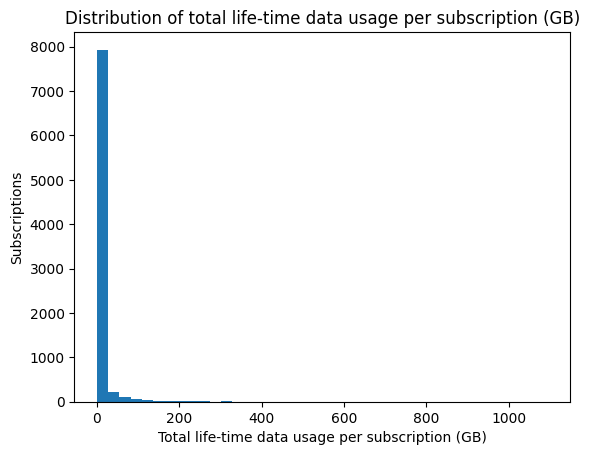

In [33]:
# Histogram of total life-time data usage per subscription
sub_avg = %sql SELECT total_data_usage/1000.0 AS total_gb FROM total_data_per_subscription;
plt.figure()
sub_avg['total_gb'].plot(kind='hist', bins=40)
plt.xlabel("Total life-time data usage per subscription (GB)")
plt.ylabel("Subscriptions")
plt.title("Distribution of total life-time data usage per subscription (GB)")
plt.show()

##### 3.1.2 For each subscription and reporting period

In [34]:
%%sql
-- Data usage percentiles per subscription and per period (30D/1M)
SELECT
  COUNT(DISTINCT subscription_id) AS number_of_subscriptions,
  COUNT(subscription_id) AS number_of_subscription_periods,
  quantile_cont (cumulative_data_usage_megabyte, 0.10) AS p10_mb,
  quantile_cont (cumulative_data_usage_megabyte, 0.25) AS p25_mb,
  quantile_cont (cumulative_data_usage_megabyte, 0.50) AS p50_mb,
  quantile_cont (cumulative_data_usage_megabyte, 0.75) AS p75_mb,
  quantile_cont (cumulative_data_usage_megabyte, 0.90) AS p90_mb,
  AVG(cumulative_data_usage_megabyte) AS mean_mb
FROM usage_joined
WHERE
  -- only inlcude monthly periods (28-31 inclusive)
  date_diff ('day', subscription_period_start, subscription_period_end) BETWEEN 28 AND 31

,number_of_subscriptions,number_of_subscription_periods,p10_mb,p25_mb,p50_mb,p75_mb,p90_mb,mean_mb
0,8043,51539,0.00,8.51,139.14,533.35,"1,674.91","1,428.85"


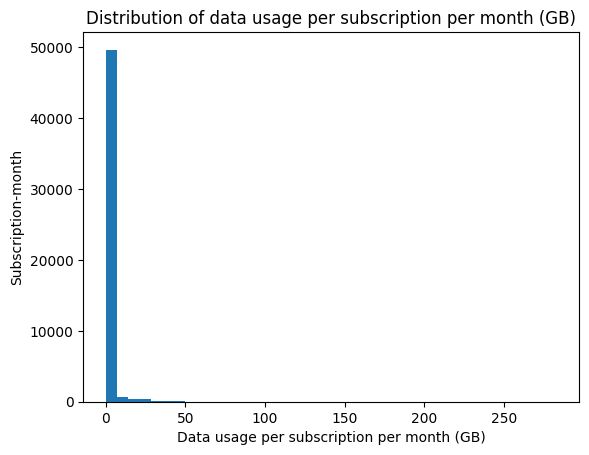

In [35]:
# Histogram of total data usage per subscription and per month
# only inlcude monthly periods (28-31 inclusive)
sub_avg = %sql SELECT cumulative_data_usage_megabyte/1000.0 AS total_gb FROM usage_joined where date_diff('day', subscription_period_start, subscription_period_end) BETWEEN 28 AND 31;
plt.figure()
sub_avg['total_gb'].plot(kind='hist', bins=40)
plt.xlabel("Data usage per subscription per month (GB)")
plt.ylabel("Subscription-month")
plt.title("Distribution of data usage per subscription per month (GB)")
plt.show()

#### 3.2 How does usage look like at different plan data allowances?

##### 3.2.1 Data allowance

##### 3.2.1.1 Data allowance per subscription per period

In [36]:
%%sql
-- Data usage percentiles per subscription and per month
-- Group by plan
SELECT
  plan_name,
  data_allowance_mb,
  COUNT(DISTINCT subscription_id) AS number_of_subscriptions,
  COUNT(subscription_id) AS number_of_subscription_periods,
  quantile_cont (cumulative_data_usage_megabyte, 0.10) AS p10_mb,
  quantile_cont (cumulative_data_usage_megabyte, 0.25) AS p25_mb,
  quantile_cont (cumulative_data_usage_megabyte, 0.50) AS p50_mb,
  quantile_cont (cumulative_data_usage_megabyte, 0.75) AS p75_mb,
  quantile_cont (cumulative_data_usage_megabyte, 0.90) AS p90_mb,
  AVG(cumulative_data_usage_megabyte) AS mean_mb,
  -- this will compute the data utilization for the 1GB and 5GB plans
  SUM(cumulative_data_usage_megabyte) / SUM(data_allowance_mb) AS utilization_ratio,
  1.0 * COUNT(subscription_id) / COUNT(DISTINCT subscription_id) AS avg_number_months
FROM
  usage_joined
  -- only inlcude monthly periods (28-31 inclusive)
WHERE
  date_diff ('day', subscription_period_start, subscription_period_end) BETWEEN 28 AND 31
GROUP BY 1,2
ORDER BY 3 DESC

,plan_name,data_allowance_mb,number_of_subscriptions,number_of_subscription_periods,p10_mb,p25_mb,p50_mb,p75_mb,p90_mb,mean_mb,utilization_ratio,avg_number_months
0,Easy Plan,"1,000.00",5805,43226,0.00,6.48,118.01,357.56,"1,030.83",369.64,0.37,7.45
1,Unlimited Plan,NaN,621,893,0.00,175.85,"1,034.72","4,234.59","10,265.58","3,353.32",NaN,1.44
2,Unlimited Data Plan,NaN,599,3784,0.00,61.01,"2,201.21","10,572.14","22,583.11","8,830.43",NaN,6.32
3,Plus Plan,"5,000.00",519,2616,0.00,31.09,364.20,"2,510.51","5,038.69","1,778.33",0.36,5.04
4,Ultra Unlimited,NaN,502,508,0.00,33.75,"15,711.57","41,212.55","88,352.89","30,992.40",NaN,1.01
5,Basic Plan,"5,000.00",270,402,0.00,7.69,537.39,"2,046.09","4,995.14","1,398.33",0.28,1.49
6,5GB,"5,000.00",97,104,0.00,0.00,"1,979.71","5,000.05","5,005.29","2,432.49",0.49,1.07
7,No Allowances Plan,0.00,4,4,0.00,0.00,337.84,"11,100.52","29,865.24","10,762.68",inf,1.00
8,5GB Plan,"5,000.00",1,2,6.93,7.83,9.34,10.84,11.74,9.34,0.00,2.00


##### 3.2.1.2 Bucketed data allowance (0G, 1G, 5G, Unlimited) per subscription per period

In [37]:
%%sql usage_data_allowance_bucketed <<
SELECT
  u.*,
  CASE
    WHEN COALESCE(is_unlimited_data, FALSE) THEN 'Unlimited'
    WHEN data_allowance_mb = 0 THEN '0GB'
    WHEN data_allowance_mb = 1000 THEN '1GB'
    WHEN data_allowance_mb = 5000 THEN '5GB'
  END AS data_allowance_bucket,
  -- this will compute the data utilization for the 1GB and 5GB plans (0GB->Inf; Unlimited -> NaN)
  cumulative_data_usage_megabyte / data_allowance_mb AS utilization_ratio,
FROM
  usage_joined u
  -- only inlcude monthly periods (28-31 inclusive)
WHERE
  date_diff ('day', subscription_period_start, subscription_period_end) BETWEEN 28 AND 31

In [38]:
%%sql
-- Data usage percentiles per subscription and per month
-- Only inlcude monthly periods (28-31 inclusive)
-- Group by data allowance bucket
SELECT
  data_allowance_bucket,
  COUNT(DISTINCT subscription_id) AS number_of_subscriptions,
  COUNT(subscription_id) AS number_of_subscription_periods,
  quantile_cont (cumulative_data_usage_megabyte, 0.10) AS p10_mb,
  quantile_cont (cumulative_data_usage_megabyte, 0.25) AS p25_mb,
  quantile_cont (cumulative_data_usage_megabyte, 0.50) AS p50_mb,
  quantile_cont (cumulative_data_usage_megabyte, 0.75) AS p75_mb,
  quantile_cont (cumulative_data_usage_megabyte, 0.90) AS p90_mb,
  AVG(cumulative_data_usage_megabyte) AS mean_mb,
  -- this will compute the data utilization for the 1GB and 5GB plans (0GB->Inf; Unlimited -> NaN)
  SUM(cumulative_data_usage_megabyte) / SUM(data_allowance_mb) AS utilization_ratio,
  1.0 * COUNT(subscription_id) / COUNT(DISTINCT subscription_id) AS avg_number_months
FROM
  usage_data_allowance_bucketed
GROUP BY 1
ORDER BY 1

,data_allowance_bucket,number_of_subscriptions,number_of_subscription_periods,p10_mb,p25_mb,p50_mb,p75_mb,p90_mb,mean_mb,utilization_ratio,avg_number_months
0,0GB,4,4,0.00,0.00,337.84,"11,100.52","29,865.24","10,762.68",inf,1.00
1,1GB,5805,43226,0.00,6.48,118.01,357.56,"1,030.83",369.64,0.37,7.45
2,5GB,887,3124,0.00,24.92,392.90,"2,543.41","5,018.16","1,750.07",0.35,3.52
3,Unlimited,1722,5185,0.00,71.79,"2,179.51","10,780.62","23,915.11","10,058.44",NaN,3.01


<Figure size 640x480 with 0 Axes>

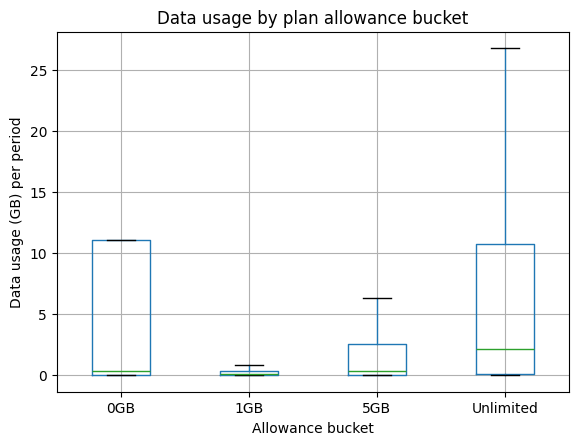

In [39]:
# Boxplot: data usage (GB) by allowance bucket
bucket_df = %sql SELECT data_allowance_bucket, cumulative_data_usage_megabyte/1000 AS data_gb FROM usage_data_allowance_bucketed;
plt.figure()
bucket_df.boxplot(by='data_allowance_bucket', column=['data_gb'],showfliers=False)
plt.suptitle("")
plt.title("Data usage by plan allowance bucket")
plt.xlabel("Allowance bucket")
plt.ylabel("Data usage (GB) per period")
plt.show()

##### 3.2.1.3 Utilization for 1GB and 5GB plans

In [40]:
%%sql
-- Data usage percentiles per subscription and per month
-- Only inlcude monthly periods (28-31 inclusive)
-- Group by data allowance bucket
SELECT
  data_allowance_bucket,
  COUNT(DISTINCT subscription_id) AS number_of_subscriptions,
  COUNT(subscription_id) AS number_of_subscription_periods,
  quantile_cont (cumulative_data_usage_megabyte, 0.10) AS p10_mb,
  quantile_cont (cumulative_data_usage_megabyte, 0.25) AS p25_mb,
  AVG(cumulative_data_usage_megabyte) AS mean_mb,
  -- this will compute the data utilization for the 1GB and 5GB plans
  SUM(cumulative_data_usage_megabyte) / SUM(data_allowance_mb) AS utilization_ratio,
FROM
  usage_data_allowance_bucketed
  -- 1G and 5G only
WHERE
  data_allowance_bucket IN ('1GB', '5GB')
GROUP BY 1 ORDER BY 2 DESC

,data_allowance_bucket,number_of_subscriptions,number_of_subscription_periods,p10_mb,p25_mb,mean_mb,utilization_ratio
0,1GB,5805,43226,0.00,6.48,369.64,0.37
1,5GB,887,3124,0.00,24.92,"1,750.07",0.35


In [41]:
%%sql
WITH
  utlization AS (
    SELECT
      data_allowance_bucket,
      CASE
        WHEN utilization_ratio >= 1.0 THEN '≥100%'
        WHEN utilization_ratio >= 0.75 THEN '75–99%'
        WHEN utilization_ratio >= 0.50 THEN '50–74%'
        WHEN utilization_ratio >= 0.25 THEN '25–49%'
        ELSE '0-25%'
      END AS utilization_band,
      COUNT(*) AS periods
    FROM usage_data_allowance_bucketed
    WHERE data_allowance_bucket IN ('1GB', '5GB')
    GROUP BY 1,2
  )
SELECT
  *,
  1.0 * periods / SUM(periods) OVER (PARTITION BY data_allowance_bucket) AS pct_period
FROM
  utlization
ORDER BY 1,2

,data_allowance_bucket,utilization_band,periods,pct_period
0,1GB,0-25%,29301,0.68
1,1GB,25–49%,5358,0.12
2,1GB,50–74%,2129,0.05
3,1GB,75–99%,1563,0.04
4,1GB,≥100%,4875,0.11
5,5GB,0-25%,1991,0.64
6,5GB,25–49%,338,0.11
7,5GB,50–74%,242,0.08
8,5GB,75–99%,206,0.07
9,5GB,≥100%,347,0.11


##### 3.2.2. Voice allowance per subscription per period

In [42]:
%%sql
-- Voice usage percentiles per subscription and per period (30D/1M)
-- Group by plan
SELECT
  plan_name,
  voice_allowance_seconds,
  COUNT(DISTINCT subscription_id) AS number_of_subscriptions,
  COUNT(subscription_id) AS number_of_subscription_periods,
  quantile_cont (cumulative_voice_usage_minutes, 0.10) AS p10_min,
  quantile_cont (cumulative_voice_usage_minutes, 0.25) AS p25_min,
  quantile_cont (cumulative_voice_usage_minutes, 0.50) AS p50_min,
  quantile_cont (cumulative_voice_usage_minutes, 0.75) AS p75_min,
  quantile_cont (cumulative_voice_usage_minutes, 0.90) AS p90_min,
  AVG(cumulative_voice_usage_minutes) AS mean_min,
  1.0 * COUNT(subscription_id) / COUNT(DISTINCT subscription_id) AS avg_number_months
FROM
  usage_joined
  -- only inlcude monthly periods (28-31 inclusive)
WHERE
  date_diff ('day', subscription_period_start, subscription_period_end) BETWEEN 28 AND 31
GROUP BY 1,2
ORDER BY 3 DESC

,plan_name,voice_allowance_seconds,number_of_subscriptions,number_of_subscription_periods,p10_min,p25_min,p50_min,p75_min,p90_min,mean_min,avg_number_months
0,Easy Plan,NaN,5805,43226,0.00,0.00,63.00,337.00,747.00,277.55,7.45
1,Unlimited Plan,NaN,621,893,0.00,0.00,0.00,0.00,0.00,0.20,1.44
2,Unlimited Data Plan,NaN,599,3784,0.00,0.00,119.50,436.00,872.40,327.17,6.32
3,Plus Plan,NaN,519,2616,0.00,0.00,108.00,445.00,878.00,306.12,5.04
4,Ultra Unlimited,NaN,502,508,0.00,0.07,126.34,488.49,"1,173.22",506.11,1.01
5,Basic Plan,NaN,270,402,0.00,0.00,0.00,0.00,0.00,0.05,1.49
6,5GB,NaN,97,104,0.00,0.00,5.93,181.93,532.48,270.04,1.07
7,No Allowances Plan,0.00,4,4,0.00,0.00,1.02,2.34,2.88,1.32,1.00
8,5GB Plan,NaN,1,2,0.01,0.02,0.04,0.05,0.06,0.04,2.00


##### 3.2.3 SMS allowance per subscription per period

In [43]:
%%sql
-- SMS usage percentiles per reporting period and per subscription
-- Group by plan
SELECT
  plan_name, sms_allowance,
  COUNT(DISTINCT subscription_id) as number_of_subscriptions,
  COUNT(subscription_id) as number_of_subscription_periods,
  quantile_cont(cumulative_sms_usage, 0.10) AS p10_sms,
  quantile_cont(cumulative_sms_usage, 0.25) AS p25_sms,
  quantile_cont(cumulative_sms_usage, 0.50) AS p50_sms,
  quantile_cont(cumulative_sms_usage, 0.75) AS p75_sms,
  quantile_cont(cumulative_sms_usage, 0.90) AS p90_sms,
  AVG(cumulative_sms_usage) AS mean_sms,
  1.0*COUNT(subscription_id) / COUNT(DISTINCT subscription_id) as avg_number_months
FROM usage_joined
-- only inlcude monthly periods (28-31 inclusive)
where date_diff('day', subscription_period_start, subscription_period_end) BETWEEN 28 AND 31
group by 1,2
order by 3 DESC

,plan_name,sms_allowance,number_of_subscriptions,number_of_subscription_periods,p10_sms,p25_sms,p50_sms,p75_sms,p90_sms,mean_sms,avg_number_months
0,Easy Plan,NaN,5805,43226,0.00,0.00,96.00,390.00,823.00,333.59,7.45
1,Unlimited Plan,NaN,621,893,0.00,0.00,0.00,4.00,12.00,7.33,1.44
2,Unlimited Data Plan,NaN,599,3784,0.00,0.00,117.00,419.00,912.00,318.90,6.32
3,Plus Plan,NaN,519,2616,0.00,2.00,152.00,504.00,962.00,351.85,5.04
4,Ultra Unlimited,NaN,502,508,0.00,1.00,122.00,388.75,978.00,348.74,1.01
5,Basic Plan,NaN,270,402,0.00,0.00,0.00,4.00,14.00,4.89,1.49
6,5GB,NaN,97,104,0.00,0.00,9.50,108.50,226.70,105.12,1.07
7,No Allowances Plan,0.00,4,4,0.00,0.00,18.50,44.00,56.60,25.50,1.00
8,5GB Plan,NaN,1,2,0.00,0.00,0.00,0.00,0.00,0.00,2.00


#### 3.3 Do subscriptions typically consume consistent amounts of data throughout their lifetime?

In [44]:
%%sql sub_usage_variability <<
-- create all the metrics / stats for each subscription
WITH
  base AS (
    SELECT
      u.subscription_id,
      u.data_allowance_bucket,
      u.subscription_period_number,
      u.cumulative_data_usage_megabyte,
      --plan-changed flag (ever changed)
      CASE
        WHEN m.subscription_id IS NOT NULL THEN TRUE
        ELSE FALSE
      END AS is_plan_changed,
      -- window functions (per-subscription stats)
      AVG(CAST(u.cumulative_data_usage_megabyte AS DOUBLE)) OVER (PARTITION BY u.subscription_id) AS mean_mb_win,
      STDDEV_SAMP(CAST(u.cumulative_data_usage_megabyte AS DOUBLE)) OVER (PARTITION BY u.subscription_id) AS sd_mb_win,
      quantile_cont (CAST(u.cumulative_data_usage_megabyte AS DOUBLE),0.5) OVER (PARTITION BY u.subscription_id) AS med_mb_win,
      -- previous period data to calculate step change
      LAG (CAST(u.cumulative_data_usage_megabyte AS DOUBLE)) OVER (PARTITION BY u.subscription_id ORDER BY u.subscription_period_number) AS prev_mb
    FROM
      usage_data_allowance_bucketed u
      LEFT JOIN sub_multi_plan m USING (subscription_id)
  ),
  flags AS (
    SELECT
      *,
      -- absolute change relative to previous data usage 
      CASE
        WHEN prev_mb IS NULL OR prev_mb = 0 THEN NULL ELSE ABS(cumulative_data_usage_megabyte - prev_mb) / prev_mb
      END AS abs_pct_change,
      -- within +-20% of mean (80%-120% of mean)
      CASE
        WHEN prev_mb > 0 AND ABS(cumulative_data_usage_megabyte - prev_mb) / prev_mb <= 0.20 THEN 1 ELSE 0
      END AS within20,
    FROM base
  )
SELECT
  subscription_id,
  is_plan_changed,
  data_allowance_bucket,
  COUNT(*) AS number_of_subscription_periods,
  MAX(mean_mb_win) AS mean_mb,
  MAX(med_mb_win) AS median_mb,
  MAX(sd_mb_win) AS sd_mb,
  CASE WHEN MAX(mean_mb_win) = 0 THEN NULL ELSE MAX(sd_mb_win) / MAX(mean_mb_win) END AS cv_mb,
  -- % of periods within +-20% of mean (80%-120% of mean)
  AVG(within20) AS share_within20,
  -- mean absolute percent change
  AVG(abs_pct_change) AS mapc
FROM flags
GROUP BY 1,2,3

In [45]:
%%sql sub_usage_variability_band<<
SELECT
  *,
  CASE
    WHEN cv_mb IS NULL THEN '1-Undefined (zero mean)'
    WHEN cv_mb < 0.25 THEN '2-Very stable (<0.25)'
    WHEN cv_mb < 0.50 THEN '3-Stable (0.25–0.5)'
    WHEN cv_mb < 1.00 THEN '4-Moderate (0.5–1.0)'
    ELSE '5-Volatile (cv≥1.0)'
  END AS cv_stability_band,
  CASE
    WHEN mapc IS NULL THEN '1-Undefined (zero mean)'
    WHEN mapc < 0.25 THEN '2-Very stable (<0.25)'
    WHEN mapc < 0.50 THEN '3-Stable (0.25–0.5)'
    WHEN mapc < 1.00 THEN '4-Moderate (0.5–1.0)'
    ELSE '5-Volatile (≥1.0)'
  END AS mapc_stability_band,
  CASE
    WHEN share_within20 IS NULL THEN '1-Undefined (zero mean)'
    WHEN share_within20 < 0.25 THEN '2- Stable (<0.25)'
    WHEN share_within20 < 0.5 THEN '3-Stable (0.25–0.50)'
    WHEN share_within20 < 0.75 THEN '4-Volatile (0.50–0.75)'
    ELSE '5-Volatile (0.75-1.0)'
  END AS share_within_20_stability_band
FROM sub_usage_variability

In [46]:
%%sql cv_distribution<<
-- CV distribution
WITH
  t AS (
    SELECT
      *,
      COUNT(*) OVER (PARTITION BY cv_stability_band) AS sub_per_band,
      COUNT(*) OVER () AS total
    FROM sub_usage_variability_band
    WHERE number_of_subscription_periods > 1
  )
SELECT DISTINCT
  cv_stability_band,
  sub_per_band AS number_of_subscriptions,
  1.0 * sub_per_band / total AS pct_subscriptions,
  total
FROM t
ORDER BY 1

In [47]:
cv_distribution

,cv_stability_band,number_of_subscriptions,pct_subscriptions,total
0,1-Undefined (zero mean),369,0.06,6179
1,2-Very stable (<0.25),259,0.04,6179
2,3-Stable (0.25–0.5),664,0.11,6179
3,4-Moderate (0.5–1.0),2187,0.35,6179
4,5-Volatile (cv≥1.0),2700,0.44,6179


In [48]:
%%sql mapc_distribution<<
-- mpac distribution
WITH
  t AS (
    SELECT
      *,
      COUNT(*) OVER (PARTITION BY mapc_stability_band) AS sub_per_band,
      COUNT(*) OVER () AS total
    FROM sub_usage_variability_band
    WHERE
      number_of_subscription_periods > 1
  )
SELECT DISTINCT
  mapc_stability_band,
  sub_per_band AS number_of_subscriptions,
  1.0 * sub_per_band / total AS pct_subscriptions,
  total
FROM t
ORDER BY 1

In [49]:
mapc_distribution

,mapc_stability_band,number_of_subscriptions,pct_subscriptions,total
0,1-Undefined (zero mean),402,0.07,6179
1,2-Very stable (<0.25),256,0.04,6179
2,3-Stable (0.25–0.5),663,0.11,6179
3,4-Moderate (0.5–1.0),1958,0.32,6179
4,5-Volatile (≥1.0),2900,0.47,6179


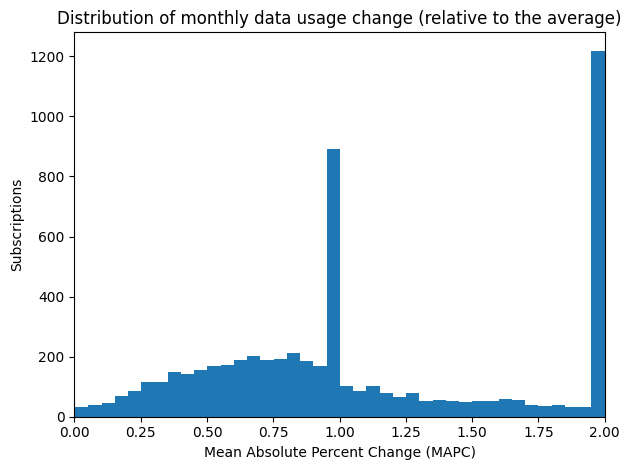

In [50]:
mapc_df = %sql SELECT mapc FROM sub_usage_variability WHERE mapc IS NOT NULL;

fig, ax = plt.subplots()
p99 = np.nanpercentile(mapc_df["mapc"], 99)
upper = min(2, float(p99))

ax.hist(mapc_df["mapc"].clip(upper=upper), bins=40)
ax.set_xlim(0, upper)
ax.set_xlabel("Mean Absolute Percent Change (MAPC)")  # correct label
ax.set_ylabel("Subscriptions")
ax.set_title("Distribution of monthly data usage change (relative to the average)")
plt.tight_layout()
plt.show()


#### 3.4 Compare the retention pattern for the most recently launched project versus the two older ones

In [51]:
%%sql firsts<<
SELECT
  organization_name,
  project_order,
  subscription_id
FROM
  usage_joined
WHERE
  subscription_period_number = 1
  AND date_diff('day', subscription_period_start, subscription_period_end) BETWEEN 28 AND 31

In [52]:
%%sql grid<<
SELECT
  f.organization_name,
  f.project_order,
  f.subscription_id,
  gs.period_n
FROM
  firsts f
  CROSS JOIN LATERAL generate_series (
    1,
    (SELECT MAX(subscription_period_number) FROM usage_joined
     WHERE date_diff('day', subscription_period_start, subscription_period_end) BETWEEN 28 AND 31)
  ) AS gs (period_n)

In [53]:
%%sql active_at<<
SELECT
  subscription_id,
  subscription_period_number AS period_n
FROM usage_joined
GROUP BY 1,2

In [54]:
%%sql retention<<
SELECT
  g.organization_name,
  g.project_order,
  g.period_n,
  COUNT(*) AS base,
  COUNT(*) FILTER (WHERE a.subscription_id IS NOT NULL) AS active,
  CAST(COUNT(a.subscription_id) AS DOUBLE) / NULLIF(COUNT(*),0) AS retention
FROM
  grid g
  LEFT JOIN active_at a ON a.subscription_id = g.subscription_id
  AND a.period_n = g.period_n
GROUP BY 1,2,3
ORDER BY 1,3

In [55]:
%%sql ret<<
SELECT
    organization_name,
    project_order,
    project_type,
    device_type,
    period_n,
    retention
FROM retention r join project p USING (organization_name) 
WHERE period_n BETWEEN 1 AND 12
ORDER BY organization_name, project_order, period_n

In [56]:
%%sql
    -- corresponds to end of 1M, 2M and 6M
    select * from ret where period_n in (2,3,7) order by 2

,organization_name,project_order,project_type,device_type,period_n,retention
0,ACME Phone,1,Connect,Phones,2,0.88
1,ACME Phone,1,Connect,Phones,3,0.78
2,ACME Phone,1,Connect,Phones,7,0.55
3,SmartDevices Inc.,2,Connect,Wearables,2,0.37
4,SmartDevices Inc.,2,Connect,Wearables,3,0.12
5,SmartDevices Inc.,2,Connect,Wearables,7,0.00
6,People Mobile,3,API,Phones,2,0.12
7,People Mobile,3,API,Phones,3,0.00
8,People Mobile,3,API,Phones,7,0.00


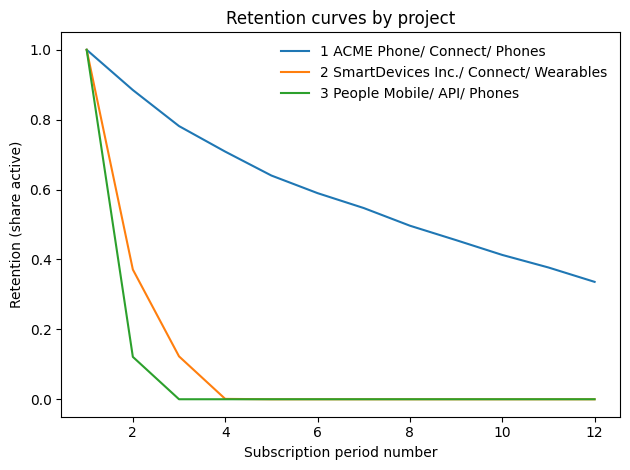

In [57]:
ret["period_n"] = pd.to_numeric(ret["period_n"], errors="coerce")
ret["retention"] = pd.to_numeric(ret["retention"], errors="coerce")

ret["label"] = ret["project_order"].astype(str) + " " + ret["organization_name"] + "/ " + ret["project_type"] + "/ "+ ret["device_type"]
wide = ret.pivot(index="period_n", columns="label", values="retention").sort_index(axis=1)

ax = wide.plot()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_xlabel("Subscription period number")
ax.set_ylabel("Retention (share active)")
ax.set_title("Retention curves by project")
ax.legend(title="", frameon=False)
plt.tight_layout()
plt.show()

#### 3.5 Compare pricing and consumption

In [58]:
%%sql
-- Price vs consumption (current-state prices near the period)
SELECT
  price_currency, plan_name,
  plan_price_amount_local AS price_amt_local,
  COUNT(*) AS periods,
  SUM(cumulative_data_usage_megabyte) AS total_mb,
  -- total data usage / number of periods / price per period
  SUM(cumulative_data_usage_megabyte) / COUNT(*) / plan_price_amount_local as total_mb_per_dollar
FROM
  usage_joined
WHERE
  plan_price_amount_local IS NOT NULL
GROUP BY 1,2,3
ORDER BY 5 DESC

,price_currency,plan_name,price_amt_local,periods,total_mb,total_mb_per_dollar
0,USD,Unlimited Data Plan,70.00,3919,"33,921,067.85",123.65
1,USD,Ultra Unlimited,35.00,615,"16,431,940.89",763.39
2,USD,Easy Plan,30.00,44600,"16,325,545.43",12.20
3,USD,Plus Plan,45.00,2722,"4,760,637.78",38.87
4,USD,Unlimited Plan,40.00,1014,"3,137,163.44",77.35
5,USD,Basic Plan,20.00,460,"583,802.63",63.46
6,USD,5GB,15.00,138,"284,906.34",137.64
7,USD,No Allowances Plan,0.00,68,"256,144.32",inf
8,USD,5GB Plan,1.00,2,18.68,9.34


### 4. Summary

**Key takeaways**

- Typical period data use (monthly subscriptions only; 96% of all subscriptions): **8,043** subscriptions; **median 139 MB**; **mean 1.4 GB**; **IQR 9–533 MB**.
- By plan data allowance (monthly subscriptions only):
  - **0 GB**: 4 subscriptions; median **337 MB**; mean **10.7 GB**; IQR **0–11.1 GB**.
  - **1 GB**: 5,805 subscriptions; median **118 MB**; mean **370 MB**; IQR **6–358 MB**. **Average utilization: 37%.**
  - **5 GB**: 887 subscriptions; median **392 MB**; mean **1.75 GB**; IQR **25 MB–2.5 GB**. **Average utilization: 35%.**
  - **Unlimited**: 1,722 subscriptions; median **2.2 GB**; mean **10.1 GB**; IQR **72 MB–10.8 GB**.
  - **Observation:** 1 GB and 5 GB plans show low utilization. 0 GB and Unlimited plans both exhibit a long tail of heavy users.
  - **Data per dollar:** Unlimited Data users consumed **123 MB/\\$**, Ultra Unlimited **763 MB/\\$**, Easy Plan (1 GB) **12 MB/\\$**. These are the plans with the highest amount data consumed and ordered in decreasing order.
- **Data usage is highly volatile.** Excluding subscriptions with only one reporting period. For each subscription, we compute each month's change relative to the previous month, and for **79% of subscriptions, the average of month-on-month changes exceeds 50%.**
- **Retention:** The latest project (**People Mobile**) underperforms older projects: **37% after 1 month**, **12% after 2 months**. The first project (**ACME Phone**) leads with **88% after 1 month**, **78% after 2 months**, and **55% after 6 months**.

**Recommendations**

1. For under-utilized plans, consider introducing an intermediate tier to better match demand and lift utilization.
2. For Unlimited plans, assess top-decile usage as a cost risk (p90 = 24 GB). Evaluate whether fair-use caps are appropriate; this will require cost data and clarity on company priorities.
3. People Mobile is the first API product for mobile phones. Investigate drivers of lower retention: compare user demographics, product features, and experience (e.g., onboarding, billing/renewal, notifications) against the two other projects. If comparability is limited, deep-dive into People Mobile user behaviour and run A/B tests to improve retention.
4. Conduct market analysis and A/B testing on plan design and consider expanding add-ons (e.g., hotspot, roaming bundles).

**Next steps / questions**

- Some subscriptions are very short (1–5 days). Understand why customers choose these products and explore targeted offerings for this segment.
- Some users do not use data in the first few months, we should investigate the causes and understand how this feeds into utilization and retention.
- Analyse retention across more dimensions (e.g., device/phone type, geography; plan details such as add-ons, network carrier; 1-month vs 30-day plans).
- Examine what happens when a plan is updated, the exisiting data does not show complete information.
- Understand the accounting logic that should applied when a subscription changes plan.

**Assumptions**

- **Subscription length.** Only subscriptions with periods between **28 and 31 days** are included (96% of all subscriptions). Shorter periods are filtered out to keep periods comparable. With daily-level data we could include these in statistical analysis.
- **Plan attributes over time.** This analysis uses the **current** plan state. A deeper cut should align the plan version to each reporting period. Relevant allowance attributes did not change across plan events; plan-validity metadata was not used.
- **Retention definition.** Retention is the share of original subscriptions that have a record at period *n*. This assumes `subscription_period_number` increments sequentially without gaps for active subscriptions. Subscriptions whose first observed period number is more than 1 (29 subscriptions in total) were excluded from the retention analysis.
- **Subsciprtion double counting.** 598 subscriptions have more than 1 plan. These subscriptions will be counted in both plans (or more if exists) when the metrics are grouped by plans.
